# Some overview visualizations for the dataset

## Load and preprocess the data

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils.KEprocessing

In [ ]:
# Define path to the CSV file
csv_path = 'data/combined_df_noNA.csv'

# Check if the file exists
if os.path.exists(csv_path):
    # If the file exists, read the DataFrame from the CSV
    combined_df = pd.read_csv(csv_path)
else:
    # If the file does not exist, call the function to prepare the DataFrame
    combined_df = utils.KEprocessing.prepare_final_df()

In [60]:
 # Define path to the CSV file
csv_path = 'data/combined_df_noNA.csv'
combined_df = pd.read_csv(csv_path)

## Neccessary modifications for plotting (run only once )

In [61]:
# Modify the 'ISPRIVATEPERSON' column to have 'residential', 'industrial', and 'unknown'
combined_df['ISPRIVATEPERSON'] = combined_df['ISPRIVATEPERSON'].map({'Ja': 'Residential', 'Nej': 'Industrial'}).fillna('Unknown')
# Ensure the 'DATE' column is of datetime type
combined_df['DATE'] = pd.to_datetime(combined_df['DATE'])

# KE customers by category and year

In [4]:
customer_counts = combined_df.groupby('ISPRIVATEPERSON')['CUSTOMER'].nunique()
customer_counts

ISPRIVATEPERSON
Ja     5097
Nej    1388
Name: CUSTOMER, dtype: int64

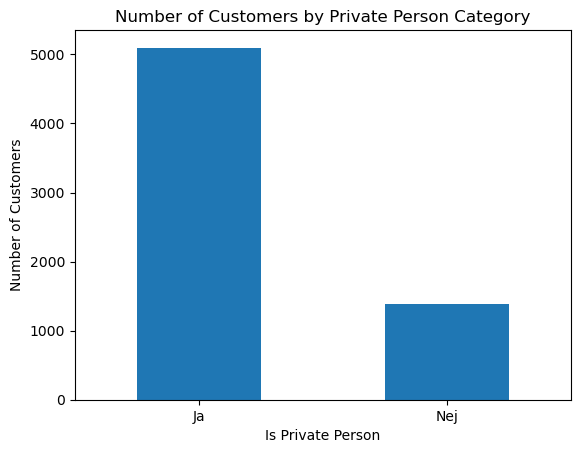

In [5]:
customer_counts.plot(kind='bar')
plt.title('Number of Customers by Private Person Category')
plt.xlabel('Is Private Person')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)  # To keep the labels on the x-axis vertical
plt.show()

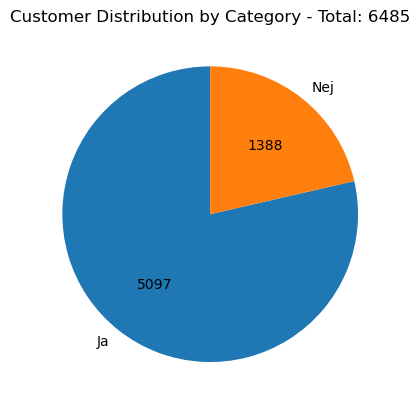

In [6]:
# Now calculate the number of unique customers for the new categories
customer_counts = combined_df.groupby('ISPRIVATEPERSON')['CUSTOMER'].nunique()

# Plot the pie chart with the actual numbers and the total
total_customers = customer_counts.sum()
customer_counts.plot(kind='pie', autopct=lambda p: f'{p * total_customers / 100 :.0f}', startangle=90, labels=customer_counts.index)
plt.title(f'Customer Distribution by Category - Total: {total_customers}')
plt.ylabel('')
plt.show()

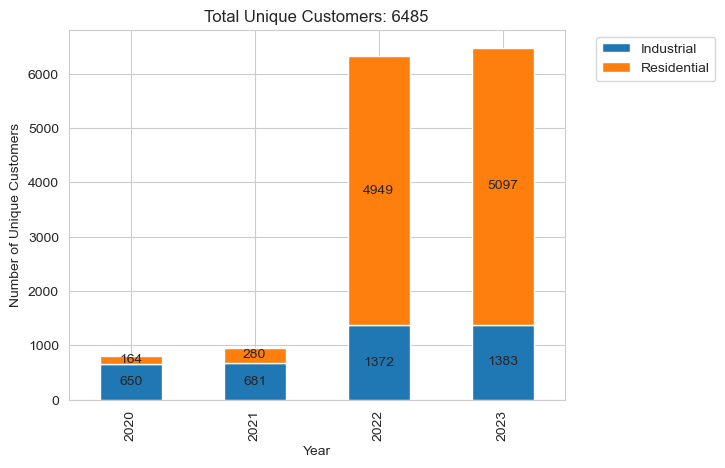

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# count unique customers per year split by category
customer_yearly = combined_df.groupby(['YEAR', 'ISPRIVATEPERSON'])['CUSTOMER'].nunique().unstack()

# Plot the stacked bar chart using seaborn
ax = customer_yearly.plot(kind='bar', stacked=True, legend=False)
# Display the total unique number of customers in combined dataframe
total_unique_customers = combined_df['CUSTOMER'].nunique()

plt.xlabel('Year')
plt.ylabel('Number of Unique Customers')

# Add labels on top of each stacked bar with the total number of customers for that year
for container in ax.containers:
    ax.bar_label(container, label_type='center')

# Move the legend outside of the plot
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add a title with the total unique customers
plt.title(f'Total Unique Customers: {total_unique_customers}')

plt.show()



## Number of Customers per Area

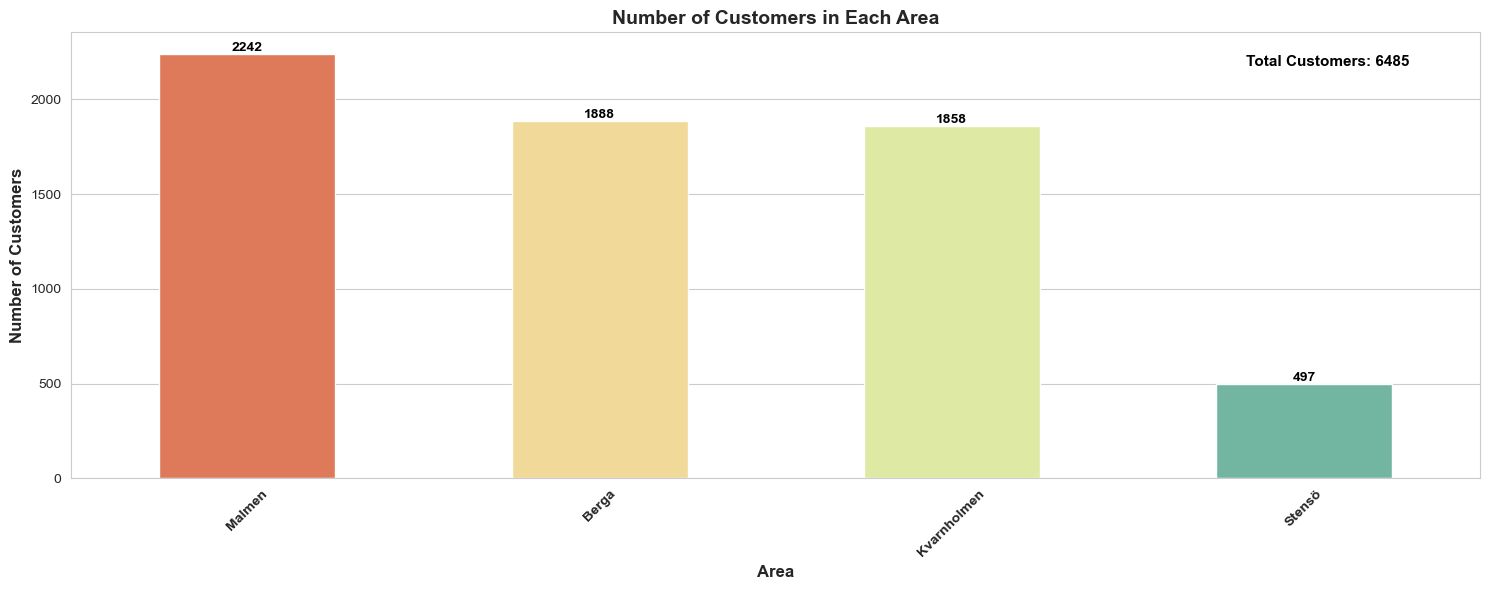

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by 'AREA' and count the unique number of 'CUSTOMER'
customers_per_area = combined_df.groupby('AREA')['CUSTOMER'].nunique()

# Calculate the total number of unique customers
total_customers = customers_per_area.sum()

# Convert to DataFrame and reset index for better readability
customers_per_area_df = customers_per_area.reset_index()

# Rename columns for clarity
customers_per_area_df.columns = ['AREA', 'Number of Customers']

# Sort the areas for better visualization
customers_per_area_df = customers_per_area_df.sort_values('Number of Customers', ascending=False)

# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Create a bar chart with Seaborn with narrower bars
plt.figure(figsize=(15, 6))
barplot = sns.barplot(x='AREA', y='Number of Customers', data=customers_per_area_df, 
                      palette='Spectral', width=0.5)  # Set width to desired value

# Rotate the x-axis labels for better readability and adjust fontsize and fontweight
plt.xticks(rotation=45, fontsize=10, fontweight='bold')

# Annotate the number of customers on top of each bar
for bar in barplot.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), 
             ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

plt.xlabel('Area', fontsize=12, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=12, fontweight='bold')
plt.title('Number of Customers in Each Area', fontsize=14, fontweight='bold')

# Add the total number of customers in the top right corner of the plot
plt.annotate(f'Total Customers: {total_customers}', xy=(0.95, 0.95), xycoords='axes fraction',
             fontsize=11, color='black', fontweight='bold', ha='right', va='top')

# Adjust the layout to fit the x-axis labels
plt.tight_layout()

# Show the plot
plt.show()


# Let's explore power consumption

## Total consumption over time (sum of everything per day)

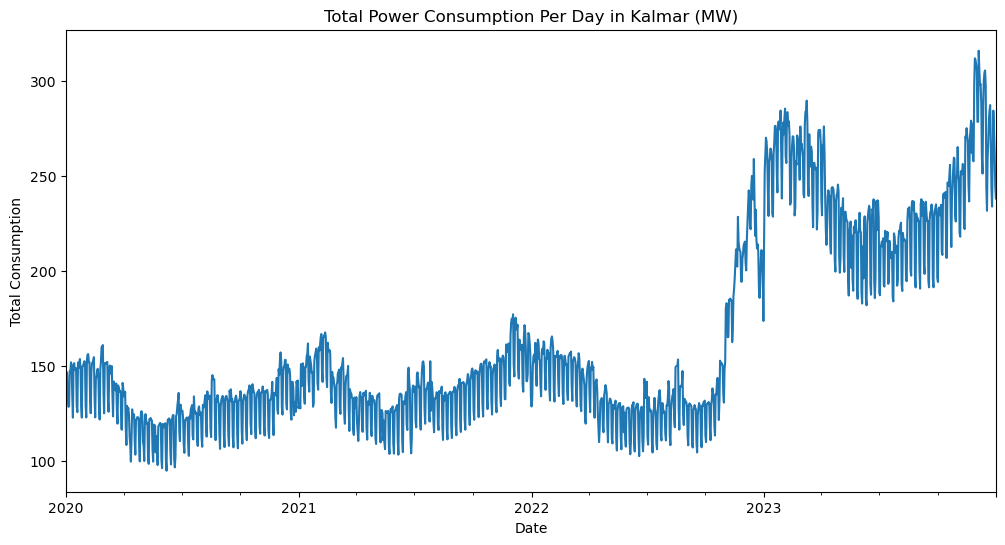

In [31]:
# Ensure the 'DATE' column is of datetime type
combined_df['DATE'] = pd.to_datetime(combined_df['DATE'])

# Select hourly columns  
hourly_columns = [f'HOUR_{i}' for i in range(24)]

# Create a new DataFrame with 'DATE' and hourly columns only
df = combined_df[['DATE'] + list(hourly_columns)]

# Resample to daily frequency (summing up hourly consumption for each day)
total_consumption_per_day = df.set_index('DATE').resample('D').sum().sum(axis=1)

# Plot total consumption over time
total_consumption_per_day.plot(figsize=(12, 6))
plt.title('Total Power Consumption Per Day in Kalmar (MW)')
plt.ylabel('Total Consumption')
plt.xlabel('Date')
plt.show()

## Split by different areas

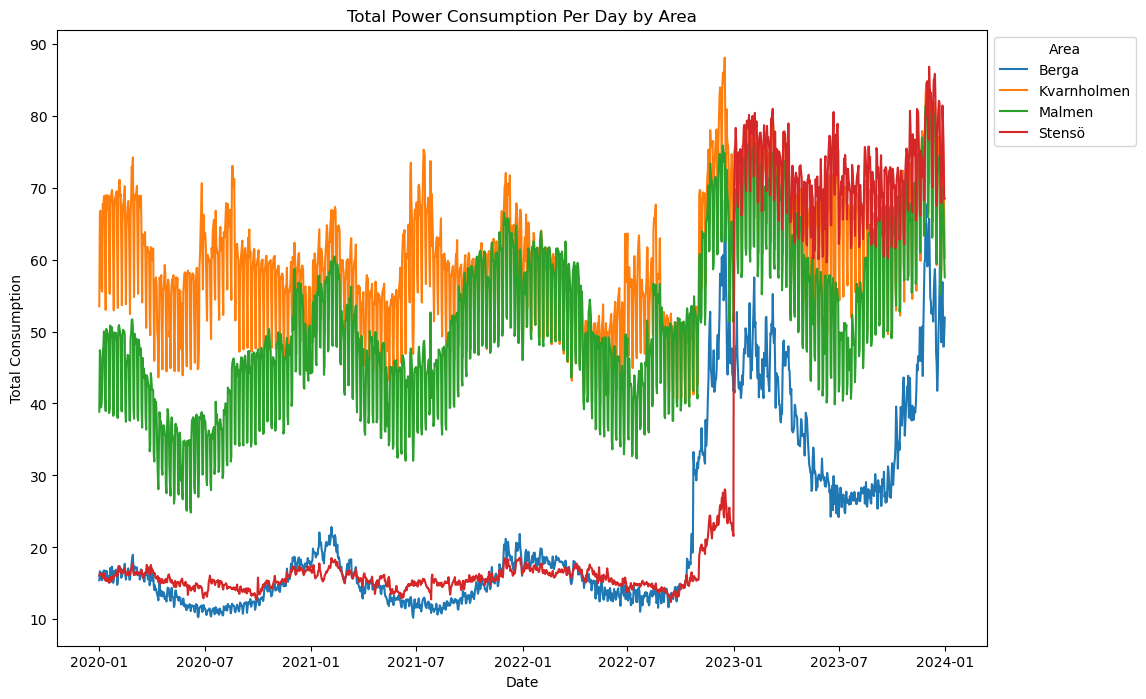

In [43]:

# Create a new DataFrame with 'AREA' and hourly columns only
df = combined_df[hourly_columns + ['AREA']].copy()

# Perform the resample per area and sum the values to get total consumption per day
total_consumption_per_day_by_area = combined_df.groupby('AREA').apply(lambda x: x.set_index('DATE').resample('D').sum())

# Sum across the hourly columns for each day of each area
total_consumption_per_day_by_area['Total'] = total_consumption_per_day_by_area[hourly_columns].sum(axis=1)

# Now we can make our plot
fig, ax = plt.subplots(figsize=(12, 8))


# Loop over each area, plotting the total consumption over time
for area, data in total_consumption_per_day_by_area.groupby(level=0):
    data.reset_index(level='DATE', inplace=True)
    ax.plot(data['DATE'], data['Total'], label=area)

plt.title('Total Power Consumption Per Day by Area')
plt.ylabel('Total Consumption')
plt.xlabel('Date')
plt.legend(title='Area', bbox_to_anchor=(1, 1))
plt.show()

## Power consumption by Building Type

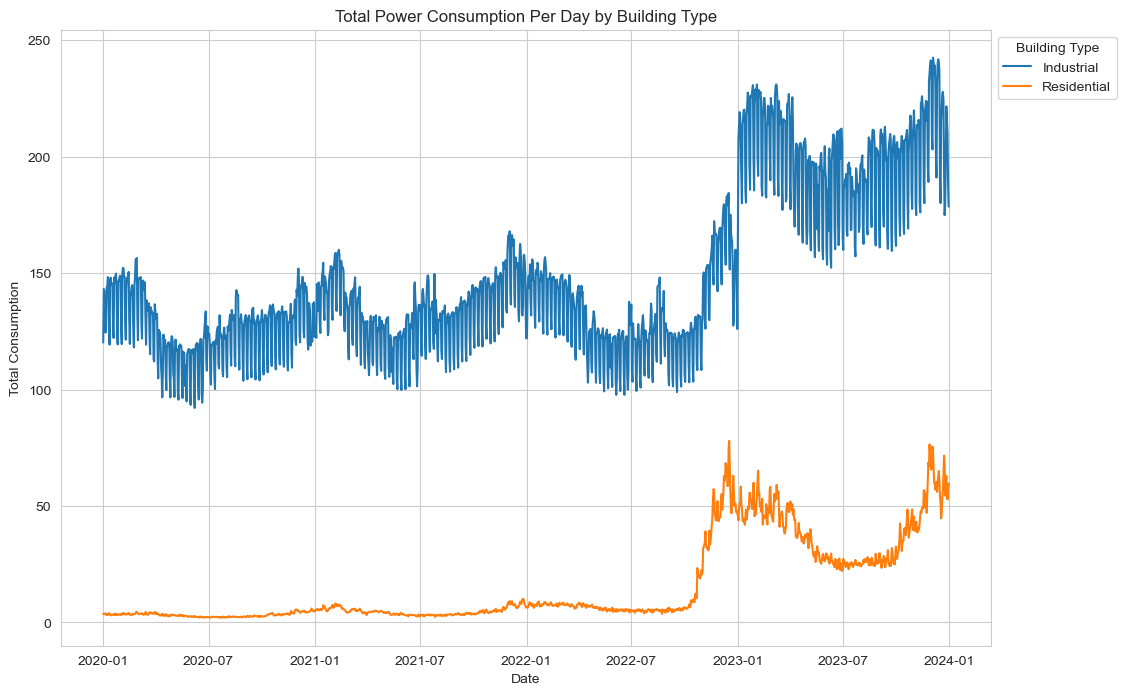

In [68]:
# Ensure the 'DATE' column is of datetime type
combined_df['DATE'] = pd.to_datetime(combined_df['DATE'])
# Perform the resample per ISPRIVATEPERSON and sum the values to get total consumption per day
total_consumption_per_day_by_type = combined_df.groupby('ISPRIVATEPERSON').resample('D', on='DATE').sum()


# Sum across the hourly columns for each day of each type
total_consumption_per_day_by_type['Total'] = total_consumption_per_day_by_type[hourly_columns].sum(axis=1)

# Now we can make our plot
fig, ax = plt.subplots(figsize=(12, 8))

# Loop over each type, plotting the total consumption over time
for building_type, data in total_consumption_per_day_by_type.groupby(level=0):
    data = data.reset_index(level='ISPRIVATEPERSON', drop=True)  # Remove the 'ISPRIVATEPERSON' level from index
    ax.plot(data.index, data['Total'], label=building_type)
    #ax.plot(data['DATE'], data['Total'], label=building_type)

plt.title('Total Power Consumption Per Day by Building Type')
plt.ylabel('Total Consumption')
plt.xlabel('Date')
plt.legend(title='Building Type', bbox_to_anchor=(1, 1))
plt.show()

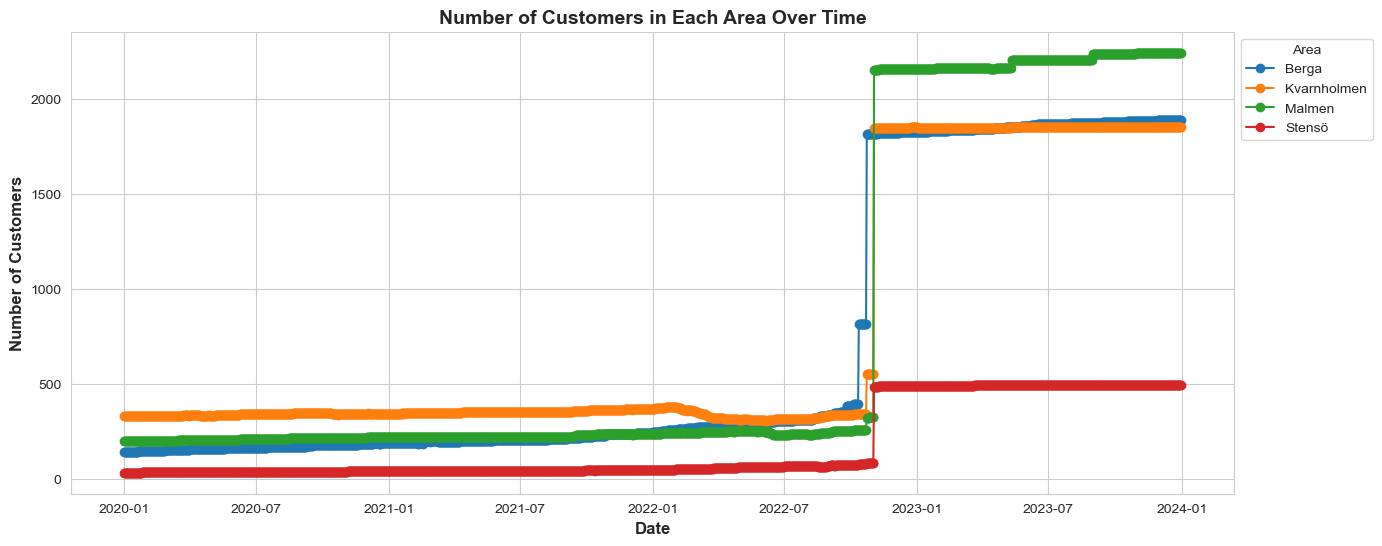

In [73]:
# Group by 'AREA' and 'DATE' and count the unique number of 'CUSTOMER'
customers_per_area_time = combined_df.groupby(['AREA','DATE'])['CUSTOMER'].nunique()

# Convert to DataFrame and reset index for better readability
customers_per_area_time_df = customers_per_area_time.reset_index()

# Rename columns for clarity
customers_per_area_time_df.columns = ['AREA', 'DATE', 'Number of Customers']

# Plot each area's customer count over time
plt.figure(figsize=(15, 6))
for area in customers_per_area_time_df['AREA'].unique():
    data = customers_per_area_time_df[customers_per_area_time_df['AREA'] == area]
    plt.plot(data['DATE'], data['Number of Customers'], marker = 'o', label = area)

# Configuring the plot aesthetics
plt.grid(True)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=12, fontweight='bold')
plt.title('Number of Customers in Each Area Over Time', fontsize=14, fontweight='bold')
plt.legend(title='Area', bbox_to_anchor=(1, 1))

plt.show()

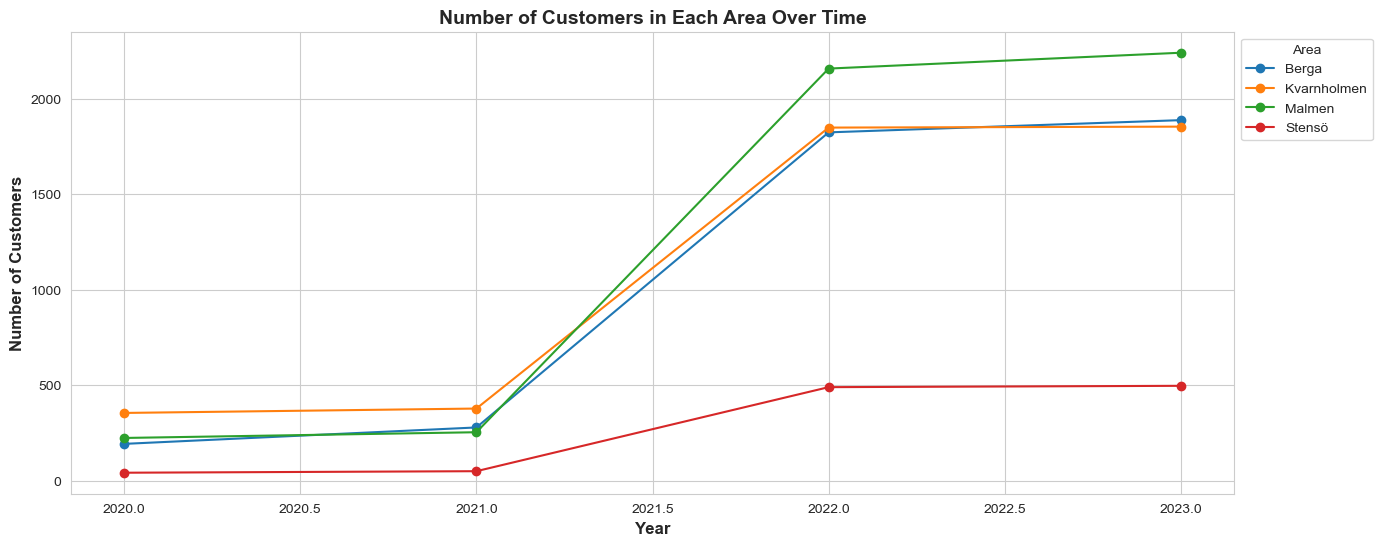

In [76]:
# Group by 'AREA' and 'YEAR' and count the unique number of 'CUSTOMER'
customers_per_area_annually = combined_df.groupby([combined_df['DATE'].dt.year, 'AREA'])['CUSTOMER'].nunique()

# Convert to DataFrame and reset index for better readability
customers_per_area_annually_df = customers_per_area_annually.reset_index()

# Rename columns for clarity
customers_per_area_annually_df.columns = ['Year', 'AREA', 'Number of Customers']

# Plot each area's customer count over time
plt.figure(figsize=(15, 6))
for area in customers_per_area_annually_df['AREA'].unique():
    data = customers_per_area_annually_df[customers_per_area_annually_df['AREA'] == area]
    
    # 'go-' results in a line plot with circular markers, while 'r-' gets a plain line plot in red.
    plt.plot(data['Year'], data['Number of Customers'], marker = 'o', label = area) 

# Configuring the plot aesthetics
plt.grid(True)
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=12, fontweight='bold')
plt.title('Number of Customers in Each Area Over Time', fontsize=14, fontweight='bold')
plt.legend(title='Area', bbox_to_anchor=(1, 1))

plt.show()